In [1]:
!unzip data.zip

Archive:  data.zip
  inflating: creditcard.csv          


In [2]:
# ## 1. Setup and Imports
# 필요한 라이브러리를 모두 불러옵니다.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight

# imbalanced-learn 라이브러리가 없다면 설치해야 합니다.
# !pip install -U imbalanced-learn
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

In [3]:
# ## 2. Data Loading and EDA
# 카드 사기 데이터셋을 로드하고 기본적인 정보를 확인합니다.
try:
    df = pd.read_csv("/content/creditcard.csv")
    print("Dataset loaded successfully.")
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'creditcard.csv' not found. Please check the file path.")
    df = pd.DataFrame()

Dataset loaded successfully.
Dataset shape: (284807, 31)


In [4]:
print("\nFirst 5 rows of the dataset:")
print(df.head())


First 5 rows of the dataset:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

  

In [5]:
# 클래스 분포 확인 (불균형 데이터)
class_counts = df['Class'].value_counts()
print("\nClass Distribution:")
print(class_counts)


Class Distribution:
Class
0    284315
1       492
Name: count, dtype: int64


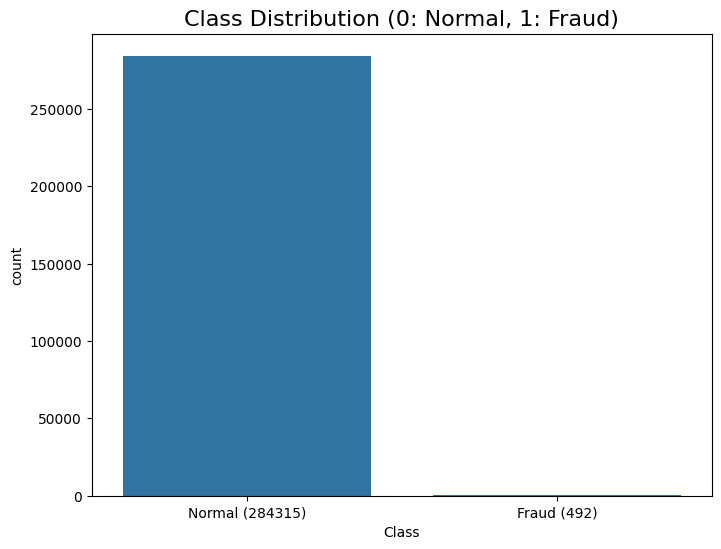

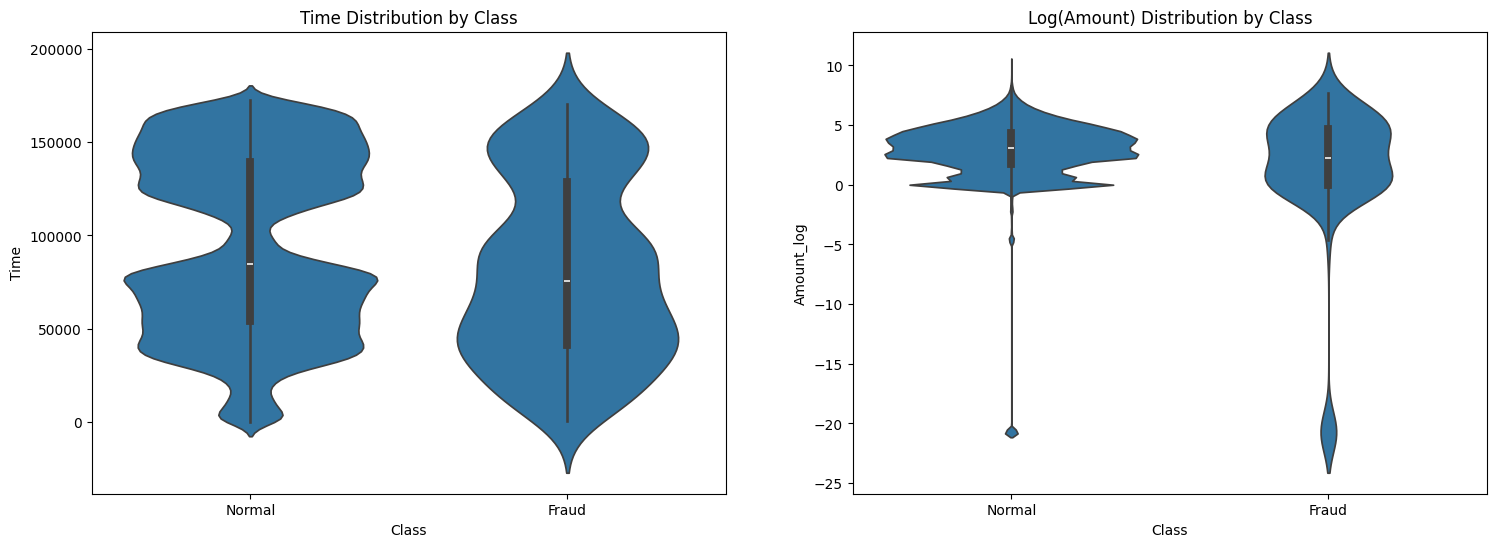

In [6]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0: Normal, 1: Fraud)', fontsize=16)
plt.xticks([0, 1], [f'Normal ({class_counts[0]})', f'Fraud ({class_counts[1]})'])
plt.show()

# 시간(Time)과 금액(Amount) 분포를 클래스별로 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
sns.violinplot(x='Class', y='Time', data=df, ax=ax1)
ax1.set_title('Time Distribution by Class')
ax1.set_xticklabels(['Normal', 'Fraud'])

# Amount의 분포가 매우 넓으므로 로그 스케일 적용하여 시각화
df['Amount_log'] = np.log(df['Amount'] + 1e-9)
sns.violinplot(x='Class', y='Amount_log', data=df, ax=ax2)
ax2.set_title('Log(Amount) Distribution by Class')
ax2.set_xticklabels(['Normal', 'Fraud'])
plt.show()
df = df.drop('Amount_log', axis=1) # 시각화 후 컬럼 제거

In [7]:
# ## 3. Data Preprocessing
# Time, Amount 피처를 스케일링하고, 데이터를 훈련/테스트 세트로 분할합니다.
if not df.empty:
    scaler = StandardScaler()
    df['scaled_Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
    df['scaled_Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
    df = df.drop(['Time', 'Amount'], axis=1)

    X = df.drop('Class', axis=1)
    y = df['Class']

    # 데이터 불균형을 유지하면서 분할 (stratify)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print(f"\nTraining data shape: {X_train.shape}")
    print(f"Test data shape: {X_test.shape}")


Training data shape: (227845, 30)
Test data shape: (56962, 30)


In [8]:
# ## 4. Model Training and Comparison
# 세 가지 다른 전략으로 모델을 학습하고 비교합니다.
if not df.empty:
    # 모델 성능을 저장할 딕셔너리
    model_performances = {}

    # ### 4.1. Baseline Model: Simple Neural Network
    print("\n--- Training Model 1: Baseline Neural Network ---")
    nn_baseline = Sequential([
        Dense(32, activation='relu', input_shape=(X_train.shape[-1],)),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    nn_baseline.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    nn_baseline.fit(X_train, y_train, epochs=10, batch_size=2048, validation_split=0.1, verbose=0)

    # ### 4.2. Model with Class Weights
    print("\n--- Training Model 2: Neural Network with Class Weights ---")
    weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = {0: weights[0], 1: weights[1]}

    nn_weighted = Sequential([
        Dense(32, activation='relu', input_shape=(X_train.shape[-1],)),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    nn_weighted.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history_weighted = nn_weighted.fit(
        X_train, y_train,
        epochs=10,
        batch_size=2048,
        validation_split=0.1,
        class_weight=class_weights,
        verbose=0
    )

    # ### 4.3. Model with SMOTE + Random Forest
    print("\n--- Training Model 3: RandomForest with SMOTE ---")
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    print(f"Data shape after SMOTE: {X_train_smote.shape}")

    rf_smote = RandomForestClassifier(random_state=42)
    rf_smote.fit(X_train_smote, y_train_smote)


--- Training Model 1: Baseline Neural Network ---

--- Training Model 2: Neural Network with Class Weights ---

--- Training Model 3: RandomForest with SMOTE ---
Data shape after SMOTE: (454902, 30)



--- Classification Report for Baseline NN ---
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56864
       Fraud       0.83      0.77      0.80        98

    accuracy                           1.00     56962
   macro avg       0.92      0.88      0.90     56962
weighted avg       1.00      1.00      1.00     56962



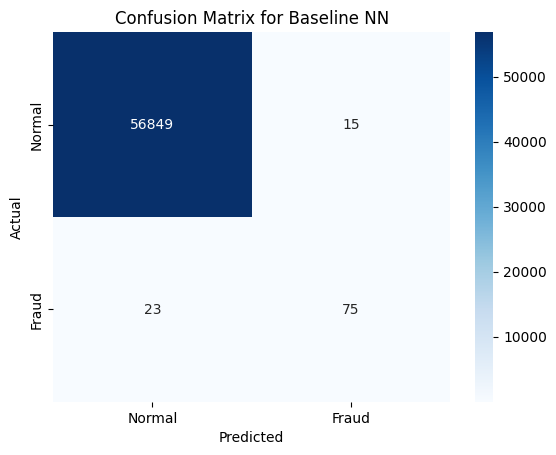


--- Classification Report for Weighted NN ---
              precision    recall  f1-score   support

      Normal       1.00      0.97      0.98     56864
       Fraud       0.05      0.91      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.94      0.54     56962
weighted avg       1.00      0.97      0.98     56962



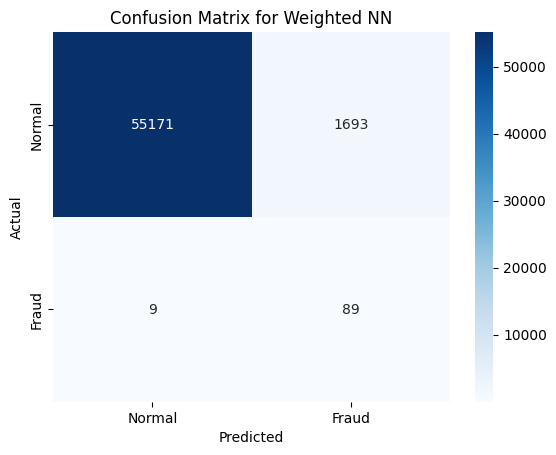


--- Classification Report for RF with SMOTE ---
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56864
       Fraud       0.81      0.81      0.81        98

    accuracy                           1.00     56962
   macro avg       0.91      0.90      0.90     56962
weighted avg       1.00      1.00      1.00     56962



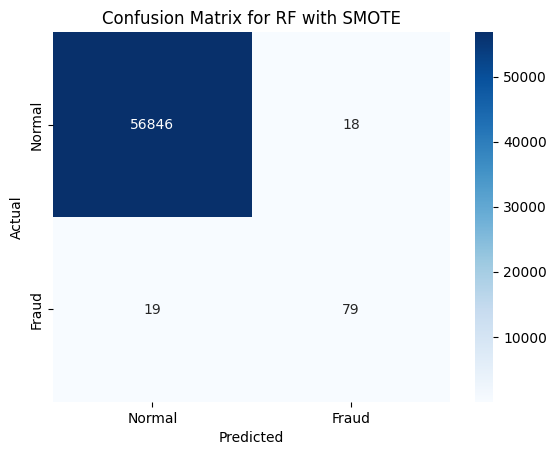

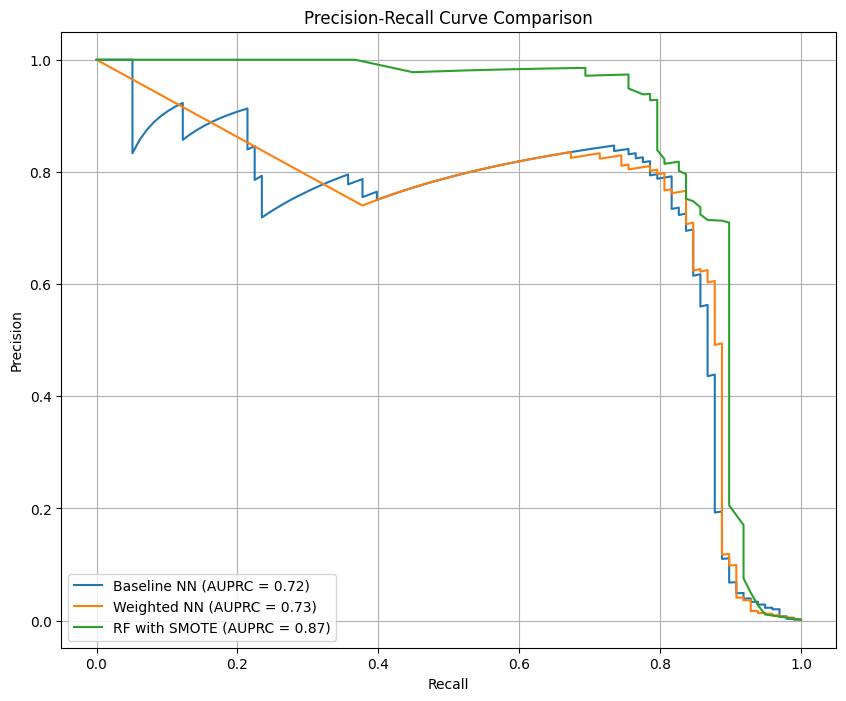


--- Final Model Performance Comparison ---
               Fraud Recall  Fraud F1-Score     AUPRC
Weighted NN        0.908163        0.094681  0.730487
RF with SMOTE      0.806122        0.810256  0.869532
Baseline NN        0.765306        0.797872  0.720137


In [9]:
# ## 5. Performance Evaluation and Comparison
if not df.empty:
    # 평가를 위한 함수 정의
    def evaluate_model(model, X_test, y_test, model_name, is_keras=True):
        if is_keras:
            y_pred_probs = model.predict(X_test, verbose=0).ravel()
            y_pred = (y_pred_probs > 0.5).astype(int)
        else: # Sklearn model
            y_pred_probs = model.predict_proba(X_test)[:, 1]
            y_pred = model.predict(X_test)

        # Classification Report
        print(f"\n--- Classification Report for {model_name} ---")
        print(classification_report(y_test, y_pred, target_names=['Normal', 'Fraud']))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
        plt.title(f'Confusion Matrix for {model_name}')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
        auprc = auc(recall, precision)

        # 성능 저장
        report = classification_report(y_test, y_pred, output_dict=True)
        model_performances[model_name] = {
            'Fraud Recall': report['1']['recall'],
            'Fraud F1-Score': report['1']['f1-score'],
            'AUPRC': auprc
        }
        return precision, recall, auprc

    # 각 모델 평가
    pr_baseline, re_baseline, auprc_baseline = evaluate_model(nn_baseline, X_test, y_test, "Baseline NN")
    pr_weighted, re_weighted, auprc_weighted = evaluate_model(nn_weighted, X_test, y_test, "Weighted NN")
    pr_smote, re_smote, auprc_smote = evaluate_model(rf_smote, X_test, y_test, "RF with SMOTE", is_keras=False)

    # PR 곡선 비교 시각화
    plt.figure(figsize=(10, 8))
    plt.plot(re_baseline, pr_baseline, label=f'Baseline NN (AUPRC = {auprc_baseline:.2f})')
    plt.plot(re_weighted, pr_weighted, label=f'Weighted NN (AUPRC = {auprc_weighted:.2f})')
    plt.plot(re_smote, pr_smote, label=f'RF with SMOTE (AUPRC = {auprc_smote:.2f})')
    plt.title('Precision-Recall Curve Comparison')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 최종 성능 비교표
    results_df = pd.DataFrame(model_performances).T
    print("\n--- Final Model Performance Comparison ---")
    print(results_df.sort_values(by='Fraud Recall', ascending=False))